## Seq2Seq LSTM model for predicting future consumption

In [46]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim
import functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Read the dataset

In [47]:
#Read dataset
path = "household_power_consumption.txt"
df = functions.load_data(path)

#Preprocess dataset and convert to hourly
df_hourly = functions.preprocess_data(df).reset_index()
df_hourly.head()

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-17 00:00:00,1.882467,0.102433,8.126667,240.961833,0.0,0.466667,0.000000
1,2006-12-17 01:00:00,3.349400,0.136933,14.246667,240.448333,0.0,25.233333,0.000000
2,2006-12-17 02:00:00,1.587267,0.078233,6.870000,245.818667,0.0,0.566667,0.000000
3,2006-12-17 03:00:00,1.662200,0.079533,7.206667,244.513500,0.0,0.766667,0.000000
4,2006-12-17 04:00:00,2.215767,0.093467,9.333333,243.855500,0.0,0.566667,8.883333


### Add features
Here we add time-related features: hour, weekday and day of the year. We use sin and cosine transforms instead of hot-encoded variables to make training faster.

We also use lagged measurements to utilize previous measurements.

In [48]:
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)

#df_hourly["value_lag_168"] = df_hourly["Global_active_power"].shift(168)
#df_hourly["value_lag_24"] = df_hourly["Global_active_power"].shift(24)
#df_hourly = df_hourly.dropna().reset_index(drop=True)

In [49]:
df_hourly

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour_sin,hour_cos,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos
0,2006-12-17 00:00:00,1.882467,0.102433,8.126667,240.961833,0.0,0.466667,0.000000,0.000000,1.000000,-0.781831,0.623490,-0.238673,0.971100
1,2006-12-17 01:00:00,3.349400,0.136933,14.246667,240.448333,0.0,25.233333,0.000000,0.258819,0.965926,-0.781831,0.623490,-0.238673,0.971100
2,2006-12-17 02:00:00,1.587267,0.078233,6.870000,245.818667,0.0,0.566667,0.000000,0.500000,0.866025,-0.781831,0.623490,-0.238673,0.971100
3,2006-12-17 03:00:00,1.662200,0.079533,7.206667,244.513500,0.0,0.766667,0.000000,0.707107,0.707107,-0.781831,0.623490,-0.238673,0.971100
4,2006-12-17 04:00:00,2.215767,0.093467,9.333333,243.855500,0.0,0.566667,8.883333,0.866025,0.500000,-0.781831,0.623490,-0.238673,0.971100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34555,2010-11-25 19:00:00,2.330467,0.151567,9.800000,237.729667,0.0,0.666667,8.366667,-0.965926,0.258819,0.433884,-0.900969,-0.580800,0.814046
34556,2010-11-25 20:00:00,1.647833,0.098033,6.826667,241.659000,0.0,0.550000,0.000000,-0.866025,0.500000,0.433884,-0.900969,-0.580800,0.814046
34557,2010-11-25 21:00:00,1.342933,0.049433,5.540000,240.698833,0.0,0.000000,0.000000,-0.707107,0.707107,0.433884,-0.900969,-0.580800,0.814046
34558,2010-11-25 22:00:00,1.247567,0.078933,5.160000,241.979500,0.0,0.000000,5.300000,-0.500000,0.866025,0.433884,-0.900969,-0.580800,0.814046


In [50]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

#Features to scale
features = ["Global_active_power","Global_reactive_power",
            "Global_intensity","Voltage",
            "Sub_metering_1","Sub_metering_2","Sub_metering_3"]

class ConsumptionDataset(Dataset):
    def __init__(self,X,y,seq_len=24,horizon=24):
        self.X = X
        self.y = y
        self.seqlen = seq_len
        self.horizon = horizon
        
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx:idx+self.seqlen],dtype=torch.float32)
        y = torch.tensor(self.y[(idx+self.seqlen):(idx+self.seqlen+self.horizon)],dtype=torch.float32)
        return X,y
    def __len__(self):
        return len(self.y)-self.seqlen-self.horizon

train_df = df_hourly.iloc[:-365*24,1:]
train_df, val_df = train_test_split(train_df,test_size=0.3,shuffle=False)
test_df = df_hourly.iloc[-365*24:,1:]


X_scaler.fit(train_df[features])
Y_scaler.fit(train_df[["Global_active_power"]])

train_targets = Y_scaler.transform(train_df[["Global_active_power"]])
train_df[features] = X_scaler.transform(train_df[features])

valid_targets = Y_scaler.transform(val_df[["Global_active_power"]])
val_df[features] = X_scaler.transform(val_df[features])

test_targets = Y_scaler.transform(test_df[["Global_active_power"]])
test_df[features] = X_scaler.transform(test_df[features])

traindata = ConsumptionDataset(train_df.to_numpy(),train_targets)
validdata = ConsumptionDataset(val_df.to_numpy(),valid_targets)
testdata = ConsumptionDataset(test_df.to_numpy(),test_targets)
trainloader = DataLoader(traindata,batch_size=32,shuffle=False)
validloader = DataLoader(validdata,batch_size=32,shuffle=False)
n_features  = df_hourly.iloc[:,1:].shape[1]

In [51]:

class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers,output_size):
        super().__init__()
        self.encoder = nn.LSTM(n_features,hidden_size,num_layers,batch_first=True)
        self.decoder = nn.LSTM(1,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
        self.output_size = output_size
        self.dropout = nn.Dropout(0.2)
        self.input_dropout = nn.Dropout(0.15)
    def forward(self,X):
        # Encoding
        _, (h,c) = self.encoder(X)
        
        #Input for decoder
        decoder_input = torch.zeros(X.size(0),1,1,device=X.device)
        outputs = []

        for i in range(self.output_size):
            out, (h,c) = self.decoder(decoder_input, (h,c))
            out = self.dropout(out)
            y = self.fc(out)
            outputs.append(y)
            decoder_input = y
        return torch.cat(outputs,dim=1)

In [52]:
from importlib import reload
reload(functions)
n_features  = df_hourly.iloc[:,1:].shape[1]
hidden_size = 64
num_layers = 1
output_size = 24

batch_size = 32
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 10**(-3))


epochs = 50
losses = []
model = model.to(device)
loss_fn = loss_fn.to(device)
model_path = "adaml_lstm.pth"
epoch_vector = np.linspace(1,epochs,epochs)
trainlossvector = np.linspace(1,epochs,epochs)
validlossvector = np.zeros(epoch_vector.shape)
min_validloss = np.inf
for epoch in range(epochs):
    trainlossvector[epoch] = functions.trainloop(trainloader,model,loss_fn,optimizer,batch_size,device)
    min_validloss,validlossvector[epoch] = functions.validationloop(validloader,model,loss_fn,min_validloss,device)
    #Save best model
    if min_validloss>=validlossvector[epoch]:
        min_validloss = validlossvector[epoch]
        torch.save(model.state_dict(),model_path)
    if (epoch+1)%1 == 0:
        print(f"Epoch: {epoch+1} | Average training loss {trainlossvector[epoch]}, Validation loss {validlossvector[epoch]}")
#torch.save(model.state_dict(),model_path)

Epoch: 1 | Average training loss 0.0006706257213034452, Validation loss 0.00048266435540859985
Epoch: 2 | Average training loss 0.0005711028194483602, Validation loss 0.00047036762859282923
Epoch: 3 | Average training loss 0.0005225994515589717, Validation loss 0.00046453614829634074
Epoch: 4 | Average training loss 0.000509392195434998, Validation loss 0.0004621591817081997
Epoch: 5 | Average training loss 0.000500704566859182, Validation loss 0.00044985554322457007
Epoch: 6 | Average training loss 0.0004927684781791002, Validation loss 0.0004306796717094727
Epoch: 7 | Average training loss 0.0004795340497999438, Validation loss 0.0004261024313234471
Epoch: 8 | Average training loss 0.00046887069788242104, Validation loss 0.00041078044672109655
Epoch: 9 | Average training loss 0.0004515475614771248, Validation loss 0.00039011079451632
Epoch: 10 | Average training loss 0.0004399013953997381, Validation loss 0.0003810048274535083
Epoch: 11 | Average training loss 0.00042934242399528233,

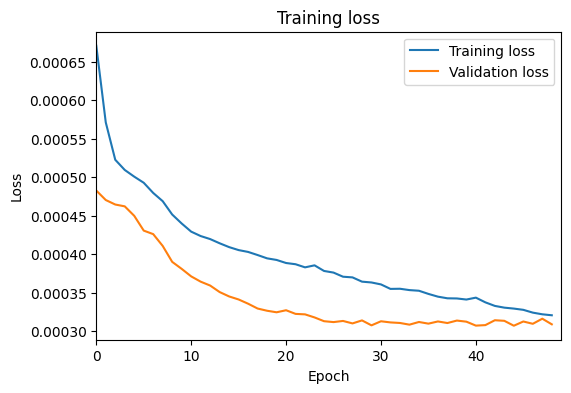

In [53]:

plt.figure(figsize=(6,4))
plt.plot(trainlossvector[:epoch],label="Training loss")
plt.plot(validlossvector[:epoch],label="Validation loss")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0,49)
plt.legend()
plt.show()

In [54]:
model_path = "adaml_lstm.pth"
n_features  = df_hourly.iloc[:,1:].shape[1]
hidden_size = 64
output_size = 24

prev_consumption = []
y_preds = []
y_actuals = []
model = Seq2SeqLSTM(n_features=n_features,hidden_size=hidden_size,num_layers=num_layers,output_size=output_size)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
model = model.to("cpu")




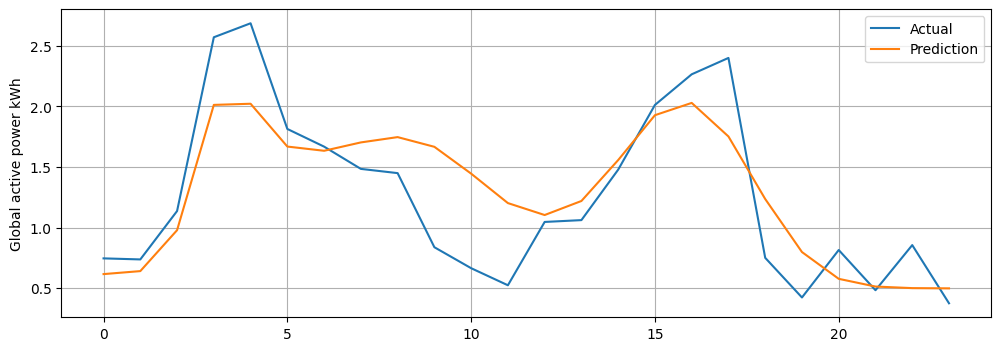

In [55]:
#Calculate samples
i = 100

X_torch, y_actual = testdata.__getitem__(i)
y_actuals = y_actual.numpy()
with torch.no_grad():
    y_pred = model(X_torch.unsqueeze(0))
y_preds = y_pred.numpy()[0]
plt.figure(figsize=(12,4))
plt.plot(Y_scaler.inverse_transform(np.array(y_actuals).reshape(-1,1)),'-',label="Actual")
plt.plot(Y_scaler.inverse_transform(np.array(y_preds).reshape(-1,1)),label="Prediction")
plt.legend()
plt.grid()
plt.ylabel("Global active power kWh")
plt.show()

C:\Users\toniv\AppData\Local\Temp\ipykernel_11752\2978102552.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_horizon["Pred"] = pred


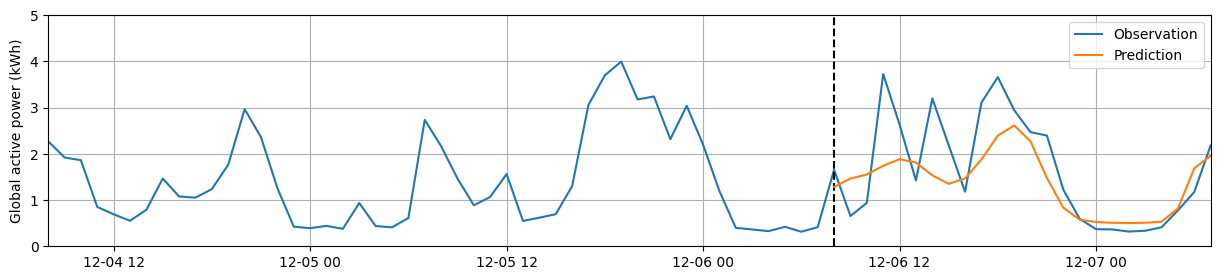

In [64]:
i = 200

#Samples before forecast
start = 0
#Lookback window
W = 48
end = start + W
#Prediction horizon
T = 24

df_sample = df_hourly.iloc[(-365*24+i):(-365*24+(W+T)+i)].reset_index(drop=True)
plt.figure(figsize=(15,3))

plt.plot(df_sample["datetime"],df_sample["Global_active_power"],label="Observation")
plt.vlines(df_sample["datetime"].iloc[end],0,5,linestyles="dashed",colors="black")

X = df_sample.iloc[start:end,1:]
X[features] = X_scaler.transform(X[features])
X_tensor = torch.tensor(X.to_numpy(),dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    pred_scaled = model(X_tensor)
    pred_scaled = pred_scaled.squeeze(0).cpu().numpy()
pred = Y_scaler.inverse_transform(pred_scaled)
df_pred_horizon = df_sample.iloc[start+end:start+end+T]
df_pred_horizon["Pred"] = pred
plt.plot(df_pred_horizon["datetime"],df_pred_horizon["Pred"],label="Prediction")
plt.xlim(df_sample["datetime"].iloc[start],df_sample["datetime"].iloc[start+end+T-1])
plt.ylim(0,5)
plt.ylabel("Global active power (kWh)")
plt.legend()
plt.grid()
plt.show()

In [66]:
df_pred_horizon

,datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour_sin,hour_cos,weekday_sin,weekday_cos,day_of_year_sin,day_of_year_cos,Pred
72,2009-11-29 00:00:00,0.578600,0.077800,2.343333,243.128500,0.000000,0.183333,1.466667,0.000000e+00,1.000000e+00,-0.781831,0.62349,-0.523416,0.852078,0.337993
73,2009-11-29 01:00:00,0.333233,0.071267,1.413333,244.272833,0.000000,0.000000,0.666667,2.588190e-01,9.659258e-01,-0.781831,0.62349,-0.523416,0.852078,0.450378
74,2009-11-29 02:00:00,0.332000,0.119967,1.366667,245.620333,0.000000,0.616667,0.666667,5.000000e-01,8.660254e-01,-0.781831,0.62349,-0.523416,0.852078,0.490919
75,2009-11-29 03:00:00,0.324767,0.063400,1.320000,246.597167,0.000000,0.000000,1.516667,7.071068e-01,7.071068e-01,-0.781831,0.62349,-0.523416,0.852078,0.497338
76,2009-11-29 04:00:00,0.334833,0.124600,1.396667,246.876500,0.000000,0.616667,0.683333,8.660254e-01,5.000000e-01,-0.781831,0.62349,-0.523416,0.852078,0.491411
77,2009-11-29 05:00:00,0.285700,0.059867,1.136667,246.513000,0.000000,0.000000,0.666667,9.659258e-01,2.588190e-01,-0.781831,0.62349,-0.523416,0.852078,0.572059
78,2009-11-29 06:00:00,0.353300,0.100433,1.440000,246.234667,0.000000,0.383333,1.450000,1.000000e+00,6.123234e-17,-0.781831,0.62349,-0.523416,0.852078,1.284047
79,2009-11-29 07:00:00,0.314900,0.099867,1.333333,244.700667,0.000000,0.233333,0.666667,9.659258e-01,-2.588190e-01,-0.781831,0.62349,-0.523416,0.852078,2.108868
80,2009-11-29 08:00:00,1.779467,0.059033,7.326667,243.548000,0.000000,0.000000,14.500000,8.660254e-01,-5.000000e-01,-0.781831,0.62349,-0.523416,0.852078,1.755834
81,2009-11-29 09:00:00,0.828267,0.114933,3.480000,239.443000,0.000000,1.050000,5.900000,7.071068e-01,-7.071068e-01,-0.781831,0.62349,-0.523416,0.852078,1.510479
